# **Assignment #1**
Due date: **31 Jan 2025 (Friday), by 11:59PM**

Instructor: Lorenzo Garlappi (lorenzo.garlappi@sauder.ubc.ca)

TA: Siyang Liu (lsy9911@student.ubc.ca), Tina Tian (tina.tian@sauder.ubc.ca)


### Instructions
a. Save this Jupyter notebook under a file name containing your Team number, e.g., `Assignment_1_Team_06.ipynb`, and submit it with your answers through Canvas

b. Enter here below the names and section of each Team members:

1. Anika Mittal, Section 201

2. Ting Chen, Section 201

3. Luke Parolin, Section 201
4. Ruihan Ma, Section 201


# Background

In this assignment, you will learn:

**Part I: WRDS introduction, WRDS connection, and data retrieval guide (15 marks)**

- **What is WRDS**: Understand the basics of Wharton Research Data Service.
- **How to connect to WRDS**: Set up and establish a connection to the WRDS platform.

- **Retrieve data from WRDS**: Learn how to query and extract data for analysis.

**Part II : Calculate mean, variance, and covariance of stock returns (25 marks)**

**Part III: Apply the mean-variance method (60 marks)**:
  - Use historical returns and variance data.
  - Select stocks based on risk-return tradeoffs using portfolio optimization techniques.

## **Part I - WRDS introduction, WRDS connection  and data retrieval guide**  

### 1. What is WRDS?

**WRDS** stands for **Wharton Research Data Service**, a platform providing access to a wide range of financial and business datasets used for academic research.

### 2. How to access WRDS

There are two main ways to access WRDS:

##### 2.1 WRDS website
- Access the website at [https://wrds-www.wharton.upenn.edu/](https://wrds-www.wharton.upenn.edu/)
- Features:
  - **User-friendly interface**: Intuitive design for easy data queries.
  - **Ease of use**: Suitable for researchers of all levels.

Data processed through the WRDS website can only be saved in WRDS but not in the local folder. Therefore, we will not use this approach.

#### 2.2 Python-WRDS connection
In this assignment, we introduce how to connect to WRDS through Python, and retrieve data from WRDS.  
- Benefits:
  - Automates data queries.
  - Enables seamless integration with your Python workflow.
  - Export and save data in the local folder.

First, we need install required packages. The following function ensures the required packages are downloaded and installed properly.

In [ ]:
# check if required packages are installed
import subprocess
import sys

def install_packages(packages):
    """
    Ensure that all specified packages are installed. If a package is not installed,
    it will be installed automatically.

    Args:
        packages (list): A list of package names to ensure are installed.

    Returns:
        None
    """
    for package in packages:
        try:
            __import__(package)
        except ImportError:
            print(f"Installing {package}...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        else:
            print(f"{package} is already installed.")

required_packages = [
    "numpy",
    "scipy",
    "pandas",
    "wrds",
    "matplotlib",
    "pathlib",
    "pandas_datareader",
    "statsmodels",
    "PyPortfolioOpt",
    "seaborn",
    "cvxpy",
    "yfinance",
]
install_packages(required_packages)

numpy is already installed.
scipy is already installed.
pandas is already installed.
wrds is already installed.
matplotlib is already installed.
pathlib is already installed.
pandas_datareader is already installed.
statsmodels is already installed.
Installing PyPortfolioOpt...
seaborn is already installed.
cvxpy is already installed.
yfinance is already installed.


We then import packages.

In [ ]:
# wrds
import wrds

# dataframe related
import pandas as pd
import numpy as np

# mean-variance optimization, plot
import matplotlib.pyplot as plt
from pypfopt import expected_returns, risk_models, expected_returns, plotting, EfficientFrontier
import seaborn as sns
import cvxpy as cp
import yfinance as yf

# handle warnings in wrds
import warnings
warnings.filterwarnings("ignore")

# paths
from pathlib import Path
root_path = Path().cwd()
data_path = root_path / 'data'
if not data_path.exists():
    data_path.mkdir()

Then, we enter credentials and connect to wrds.
In the following code, enter the user name and password to connect to wrds.

In [ ]:
# WRDS connection
# wrds_username = 'your_username'
wrds_username = 'eileenbc'

try:
    print("Establishing connection to WRDS database...")
    params = {
        'wrds_hostname': wrds.sql.WRDS_POSTGRES_HOST,
        'wrds_port': wrds.sql.WRDS_POSTGRES_PORT,
        'wrds_dbname': wrds.sql.WRDS_POSTGRES_DB,
        'wrds_username': wrds_username,
        'wrds_connect_args': wrds.sql.WRDS_CONNECT_ARGS,
    }

    conn = wrds.Connection(autoconnect=True, **params)
    print("Successfully connected to WRDS database.")
except Exception as e:
    print(f"Failed to connect to WRDS database: {e}")


Establishing connection to WRDS database...
Enter your WRDS username [eileenbc]:chenting19
Enter your password:··········
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?: y
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done
Successfully connected to WRDS database.


### 3. Using the WRDS Package  

#### 3.1 Key Functions in the `wrds` Package  

The following functions are essential for exploring and querying data in WRDS:  

- **`list_libraries`**: Lists all libraries available in your WRDS account.  
- **`list_tables`**: Lists all datasets within a specific library.  
- **`describe_table`**: Lists all variables (columns) in a specific dataset.  
- **`get_table`**: Fetches data from a dataset with optional filters and limits.  
- **`raw_sql`**: Executes a custom SQL query against a dataset.  
- **`get_row_count`**: Returns the number of rows in a dataset.  

#### 3.2 Querying the Dataset Structure (Metadata)  

##### 3.2.1 List All Libraries  

```python
sorted(conn.list_libraries())
```

- Lists all libraries available at WRDS in alphabetical order.  
- Access to a library depends on your subscription.  

##### 3.2.2 List Datasets in a Library  

```python
conn.list_tables(library="library_name")
```

- Replace `"library_name"` with the library you want to query (e.g., `crsp`, `comp`).  

##### 3.2.3 List Variables in a Dataset  

```python
conn.describe_table(library="library_name", table="dataset_name")
```

- Replace `"library_name"` and `"dataset_name"` with appropriate names.  
- Both are case-sensitive and must be lowercase.  

Alternatively, a comprehensive dataset list is available on the WRDS website, detailing libraries, datasets, variables, and previews.  

#### 3.3 Querying WRDS Data  

##### 3.3.1 Using `get_table()`  

Simplifies querying by specifying library, dataset, and optional parameters like columns and `obs`.  

```python
data = conn.get_table(library='djones', table='djdaily', columns=['date', 'dji'], obs=10)
```

##### 3.3.2 Using `raw_sql()`  

The `raw_sql()` function allows you to use basic SQL queries to extract data from a database. Here's an overview of the most fundamental SQL commands:

- **`SELECT`**: Specifies the columns you want to retrieve.  
- **`FROM`**: Indicates the table where the data resides.  
- **`WHERE`**: Adds filtering conditions to retrieve specific rows.  
- **`JOIN`**: Combines data from multiple tables based on a common column.  
- **`LIMIT`**: Restricts the number of rows returned.  

**Basic SQL Syntax**:

```sql
SELECT column1, column2
FROM schema_name.table_name
WHERE condition
JOIN another_table ON table_name.key = another_table.key
LIMIT number_of_rows;
```

**Example Usage in `raw_sql()`**:

```python
data = conn.raw_sql(
    f"""
    SELECT gvkey, datadate, seq, ceq, at, lt, txditc, txdb, itcb, pstkrv,
           pstkl, pstk, capx, oancf, sale, cogs, xint, xsga "
    FROM comp.funda
    WHERE indfmt = 'INDL'
         AND datafmt = 'STD'
         AND consol = 'C'
         AND curcd = 'USD'
         AND datadate BETWEEN '{start_date}' AND '{end_date}'""",
    date_cols=['datadate']
)
```

**Key SQL Components in This Query**:

- **`SELECT`**: Specifies the columns to retrieve. Here, columns like `gvkey`, `datadate`, `seq`, `ceq`, and others are selected.  
- **`FROM`**: Indicates the source table `comp.funda`.  
- **`WHERE`**: Adds filtering conditions:
  - `indfmt = 'INDL'`: Industrial format data.  
  - `datafmt = 'STD'`: Standardized format.  
  - `consol = 'C'`: Consolidated financial data.  
  - `curcd = 'USD'`: Data reported in U.S. dollars.  
  - `datadate BETWEEN '{start_date}' AND '{end_date}'`: Restricts the date range.  
- **`f-string`**: Dynamically injects the `start_date` and `end_date` variables into the query.  
- **`date_cols`**: Ensures the `datadate` column is parsed as a `datetime` object.

##### 3.3.3 Using `get_row_count()`  

Retrieves the row count of a dataset.  

```python
count = conn.get_row_count('djones', 'djdaily')
```

##### 3.3.4 Joining Data from Separate Datasets  

Join datasets for analysis, e.g., combining Compustat Fundamentals (`comp.funda`) with Compustat Pricing (`comp.secm`):  

```python
conn.raw_sql("""
    SELECT a.gvkey, a.datadate, a.tic, a.conm, a.at, a.lt, b.prccm, b.cshoq
    FROM comp.funda a
    JOIN comp.secm b ON a.gvkey = b.gvkey AND a.datadate = b.datadate
    WHERE a.tic = 'IBM' AND a.datafmt = 'STD' AND a.consol = 'C' AND a.indfmt = 'INDL'
""")
```

##### 3.3.5 Passing Parameters to SQL  

The `raw_sql()` method supports parameterized SQL queries:  

```python
params = {"tickers": ("0015B", "0030B", "0032A")}
data = conn.raw_sql(
    "SELECT datadate, gvkey, cusip FROM comp.funda WHERE tic IN %(tickers)s",
    params=params,
)
```



The following code lists the first 10 libraries in WRDS and the first 10 tables names of crsp library.

In [ ]:
print(conn.list_libraries()[0:10])
# We select crsp library, and take a look at the tables.
print(conn.list_tables(library='crsp')[0:10])

# We select library crsp, table name is msf_v2, and take a look at the observations.
crsp_monthly = conn.get_table(library='crsp', table='msf_v2', obs=5)
crsp_monthly.head(3)

['aha_sample', 'ahasamp', 'auditsmp', 'auditsmp_all', 'bank', 'bank_all', 'bank_premium_samp', 'banksamp', 'block', 'block_all']
['acti', 'asia', 'asib', 'asic', 'asio', 'asix', 'bmdebt', 'bmheader', 'bmpaymts', 'bmquotes']


,permno,hdrcusip,permco,siccd,nasdissuno,yyyymm,mthcaldt,mthcompflg,mthcompsubflg,mthprc,...,issuertype,securitytype,securitysubtype,sharetype,exchangetier,primaryexch,tradingstatusflg,conditionaltype,shrout,mthfloatshrqty
0,10000,68391610,7952,3990,10396,198601,1986-01-31,Y,Y1,4.375000,...,ACOR,EQTY,COM,NS,SC1,Q,A,RW,3680,None
1,10000,68391610,7952,3990,10396,198602,1986-02-28,G,G1,3.250000,...,ACOR,EQTY,COM,NS,SC1,Q,A,RW,3680,None
2,10000,68391610,7952,3990,10396,198603,1986-03-31,G,G1,4.437500,...,ACOR,EQTY,COM,NS,SC1,Q,A,RW,3680,None


### 4. Introduction to the CRSP Database

This section introduces the CRSP database, a main database in asset pricing research. For more details, refer to the official documentation: [WRDS Overview of CRSP U.S. Stock Database](https://wrds-www.wharton.upenn.edu/pages/support/manuals-and-overviews/crsp/stocks-and-indices/overview-crsp-us-stock-database/).

- The CRSP U.S. Stock database provides stock prices, returns, and event information.

#### 4.1. General Description

The CRSP U.S. Stock database includes:

- End-of-day and end-of-month prices for primary listings on NYSE, NYSE MKT, NASDAQ, and Arca exchanges.
- Basic market indices.
- Comprehensive corporate action information and highly accurate total return calculations.

#### 4.2. Coverage

##### 4.2.1. Key Features

The CRSP U.S. Stock database contains the following:

- **Price and Quote Data**: Open, close, bid/low, ask/high, trade-only.
- **Returns**:
  - Holding period returns with and without dividends.
  - Excess returns and other derived data items.
- **Market Information**:
  - Market capitalization.
  - Shares outstanding.
  - Trading volume.
- **Corporate Actions**: Includes delisting information.
- **Identifiers and Descriptors**: Supplemental data items for security identification.

##### 4.2.2. Exchange Coverage

- **NYSE**: Data starts from December 31, 1925.
- **NYSE MKT**: Data starts from July 2, 1962.
- **NASDAQ**: Data starts from December 14, 1972.
- **Arca**: Data starts from March 8, 2006.

##### 4.2.3. Market Indices

- Equal and value-weighted returns for CRSP NYSE, NYSE MKT, NASDAQ, and Arca, with and without dividends.
- Composite indices for S&P 500 and NASDAQ.
- **S&P 500 Constituent Data**: Available through the CRSP Indices product.

#### 4.3. Share Type (SHRCD) Coverage

CRSP U.S. Stock includes:

- **Equity Types**:
  - Common stocks.
  - Certificates.
  - ADRs (American Depositary Receipts).
  - Shares of Beneficial Interest.
  - Units (e.g., Depository Units, Units of Limited Partnership Interest).
  - ETFs (Exchange-Traded Funds).
  - Closed-end mutual funds.
- **Special Securities**:
  - Foreign companies traded on major U.S. exchanges.
  - Americus Trust Components (Primes and Scores).
  - HOLDRs Trusts.
  - REITs (Real Estate Investment Trusts).

Refer to the "Share Codes Security Type" section in the official overview for more details.

#### 4.4. Exclusions

The CRSP U.S. Stock database does not include:

- Rights and warrants.
- Preferred shares.
- Units representing common stocks bundled with rights or warrants.
- Over-the-counter securities.
- When-issued trading data.

The following code retrieves data from WRDS library 'crsp', table 'msf_v2', limiting the observations to 5 records.

In [ ]:
crsp_monthly = conn.get_table(library='crsp', table='msf_v2', obs=5)
crsp_monthly

,permno,hdrcusip,permco,siccd,nasdissuno,yyyymm,mthcaldt,mthcompflg,mthcompsubflg,mthprc,...,issuertype,securitytype,securitysubtype,sharetype,exchangetier,primaryexch,tradingstatusflg,conditionaltype,shrout,mthfloatshrqty
0,10000,68391610,7952,3990,10396,198601,1986-01-31,Y,Y1,4.375000,...,ACOR,EQTY,COM,NS,SC1,Q,A,RW,3680,None
1,10000,68391610,7952,3990,10396,198602,1986-02-28,G,G1,3.250000,...,ACOR,EQTY,COM,NS,SC1,Q,A,RW,3680,None
2,10000,68391610,7952,3990,10396,198603,1986-03-31,G,G1,4.437500,...,ACOR,EQTY,COM,NS,SC1,Q,A,RW,3680,None
3,10000,68391610,7952,3990,10396,198604,1986-04-30,G,G1,4.000000,...,ACOR,EQTY,COM,NS,SC1,Q,A,RW,3793,None
4,10000,68391610,7952,3990,10396,198605,1986-05-30,G,G1,3.109375,...,ACOR,EQTY,COM,NS,SC1,Q,A,RW,3793,None


The following code retrieves data from WRDS Fama-French library 'ff', table 'factors_monthly', limiting the observations to 5 records.

In [ ]:
ff3_factors_monthly = conn.get_table(library='ff', table='factors_monthly', obs=5)
ff3_factors_monthly

,date,mktrf,smb,hml,rf,year,month,umd,dateff
0,1926-07-01,0.029600,-0.025600,-0.024300,0.00220,1926.0,7.0,None,1926-07-31
1,1926-08-01,0.026400,-0.011700,0.038200,0.00250,1926.0,8.0,None,1926-08-31
2,1926-09-01,0.003600,-0.014000,0.001300,0.00230,1926.0,9.0,None,1926-09-30
3,1926-10-01,-0.032400,-0.000900,0.007000,0.00320,1926.0,10.0,None,1926-10-30
4,1926-11-01,0.025300,-0.001000,-0.005100,0.00310,1926.0,11.0,None,1926-11-30


### 5. Managing WRDS Connections

WRDS allows up to **5 simultaneous connections**. Always close a connection when finished to avoid connection issues:
```python
import wrds
conn = wrds.Connection()
data = conn.raw_sql("SELECT * FROM djones.djdaily")
conn.close()
```


##### **Question 1: Retrieve data from WRDS (15 marks)**

We've provide you how to retrieve data from wrds using wrds.raw_sql, now please get the data from wrds following the instruction:

**1.1 Retrieve data from CRSP library, msf_v2 table (5 marks)**

Variables to be retrieved are:
permno, siccd, mthcaldt, mthret, mthretx, mthcap,ticker

Start date: 12/31/2010

End date: 12/31/2023

**1.2 Retrieve data from ff library, factors_monthly table (5 marks)**

Variables to be retrieved are:
date, mktrf, smb, hml, rf, get the whole table

Start date: 12/31/2010

End date: 12/31/2023

**1.3 Merge CRSP stock price data in 1.1 with Fama-French three factors data in 1.2 (5 marks)**

1.1 Retreive WRDS data from the CRSP library, msf_v2 table, name it 'crsp_monthly'. (5 marks)

In [ ]:
# define start date and end date
start_date = "12/31/2010"
end_date = "12/31/2023"

In [ ]:
crsp_monthly = conn.raw_sql(
    f"""
    SELECT permno, siccd, mthcaldt, mthret, mthretx, mthcap, ticker
    FROM crsp.msf_v2
     WHERE mthcaldt BETWEEN '{start_date}' AND '{end_date}' """,
     date_cols=['mthcaldt'])

# Display
crsp_monthly

,permno,siccd,mthcaldt,mthret,mthretx,mthcap,ticker
0,10001,4925,2010-12-31,0.052308,0.047809,8.241368e+04,EGAS
1,10002,6020,2010-12-31,0.063745,0.063745,4.709613e+04,BTFG
2,10025,3081,2010-12-31,0.079002,0.079002,1.594368e+05,AEPI
3,10026,2052,2010-12-31,0.057009,0.054426,8.944661e+05,JJSF
4,10028,5094,2010-12-31,0.043902,0.043902,4.208952e+04,DGSE
...,...,...,...,...,...,...,...
207452,93426,3676,2023-12-29,0.117416,0.117416,4.262157e+05,VPG
207453,93427,3827,2023-12-29,0.175602,0.175602,6.914879e+06,FN
207454,93429,7374,2023-12-29,-0.019924,-0.019924,1.884808e+07,CBOE
207455,93434,9999,2023-12-29,0.065449,0.065449,3.012730e+04,SANW


1.2 Retrieve data from ff library, factors_monthly table, name it 'ff3_factors_monthly'. (5 marks)

In [ ]:
ff3_factors_monthly = conn.raw_sql(
    f"""
    SELECT date, mktrf, smb, hml, rf
    FROM ff.factors_monthly
    WHERE date BETWEEN '{start_date}' AND '{end_date}'""",
date_cols=['date'])
ff3_factors_monthly

,date,mktrf,smb,hml,rf
0,2011-01-01,0.0199,-0.0250,0.0082,0.0001
1,2011-02-01,0.0349,0.0153,0.0127,0.0001
2,2011-03-01,0.0046,0.0254,-0.0183,0.0001
3,2011-04-01,0.0290,-0.0038,-0.0243,0.0000
4,2011-05-01,-0.0127,-0.0059,-0.0212,0.0000
...,...,...,...,...,...
151,2023-08-01,-0.0239,-0.0320,-0.0108,0.0045
152,2023-09-01,-0.0524,-0.0249,0.0145,0.0043
153,2023-10-01,-0.0318,-0.0388,0.0019,0.0047
154,2023-11-01,0.0883,-0.0003,0.0166,0.0044


1.3 Merge CRSP stock price data in 1.1 with Fama-French three factors data in 1.2, name it 'cleaned_data'. (5 marks)


hint: pd.merge is the function to merge two dataframes. You can merge two dataframes on a common column. For example, if you want to merge df1 and df2 on column 'date', you can use the following code:
```python
pd.merge(df1, df2, on='date')
```

In [ ]:
crsp_monthly['year'] = crsp_monthly['mthcaldt'].dt.year
crsp_monthly['month'] = crsp_monthly['mthcaldt'].dt.month
ff3_factors_monthly['year'] = ff3_factors_monthly['date'].dt.year
ff3_factors_monthly['month'] = ff3_factors_monthly['date'].dt.month

cleaned_data = pd.merge(crsp_monthly, ff3_factors_monthly, on=['year', 'month'], how='outer')
cleaned_data

,permno,siccd,mthcaldt,mthret,mthretx,mthcap,ticker,year,month,date,mktrf,smb,hml,rf
0,10001,4925,2010-12-31,0.052308,0.047809,8.241368e+04,EGAS,2010,12,NaT,NaN,NaN,NaN,NaN
1,10002,6020,2010-12-31,0.063745,0.063745,4.709613e+04,BTFG,2010,12,NaT,NaN,NaN,NaN,NaN
2,10025,3081,2010-12-31,0.079002,0.079002,1.594368e+05,AEPI,2010,12,NaT,NaN,NaN,NaN,NaN
3,10026,2052,2010-12-31,0.057009,0.054426,8.944661e+05,JJSF,2010,12,NaT,NaN,NaN,NaN,NaN
4,10028,5094,2010-12-31,0.043902,0.043902,4.208952e+04,DGSE,2010,12,NaT,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1207452,93426,3676,2023-12-29,0.117416,0.117416,4.262157e+05,VPG,2023,12,2023-12-01,0.0487,0.0636,0.0492,0.0043
1207453,93427,3827,2023-12-29,0.175602,0.175602,6.914879e+06,FN,2023,12,2023-12-01,0.0487,0.0636,0.0492,0.0043
1207454,93429,7374,2023-12-29,-0.019924,-0.019924,1.884808e+07,CBOE,2023,12,2023-12-01,0.0487,0.0636,0.0492,0.0043
1207455,93434,9999,2023-12-29,0.065449,0.065449,3.012730e+04,SANW,2023,12,2023-12-01,0.0487,0.0636,0.0492,0.0043


Note: when the data is large, you can save the data to a pickle file and reload it. The following code achieves this.

In [ ]:
# when the data is large, you can save the data to a pickle file and reload it
# pickling is a way of serializing Python objects into a binary format, which allows you to save the object (in this case, the DataFrame) and load it back later without losing its structure or data types#
cleaned_data.to_pickle(data_path / 'cleaned_data.pkl')
cleaned_data = pd.read_pickle(data_path / 'cleaned_data.pkl')

## **Part II - Calculate the mean, variance, and covariance of stock returns**

In this part, we will calculate the mean, variance, and covariance of stock returns. Let's see an example of how to calculate the mean, variance, and covariance of stock returns:

Assume we have return data for 2 stocks across 2 time periods. Here, "permno" is the unique id of stock.

| permno | date | return |
| ------------- | ------- | ------------------- |
| 101           | 2024-01 | 0.05                |
| 102           | 2024-01 | 0.10                |
| 101           | 2024-02 | -0.02               |
| 102           | 2024-02 | 0.04                |

To calculate the mean and the variance of stock returns programmatically, we can leverage the `groupby` function in pandas. The `groupby` function is particularly useful for aggregating data by specific groups, such as `permno` in this case.


Below is the code to implement calculate mean stock returns, variance of stock returns, and the covariance matrix in pandas:  

In [ ]:
# Here is an exapmle:
import pandas as pd

# Example Data
data = {
    "permno": [101, 102, 101, 102],
    "date": ["2024-01", "2024-01", "2024-02", "2024-02"],
    "return": [0.05, 0.10, -0.02, 0.04],
}

# Create DataFrame
df = pd.DataFrame(data)

# 1. Calculate the mean of stock returns, you can also change 'permno' to 'ticker'
mean_returns = df[['permno','return']].groupby('permno').mean().reset_index()

# 2. Calculate variance of stock returns, you can also change 'permno' to 'ticker'
var_returns = df[['permno','return']].groupby('permno').var().reset_index()

# 3. Calculate covariance of stock returns, you can also change 'permno' to 'ticker'
# note: if you use 'ticker' as key, you need change 'permno' to 'ticker'
def calculate_covariance_returns(df):
    # df is a data frame that in long format (panel data)
    df_wide = df.pivot(index='date', columns='permno', values='return').reset_index()
    df_wide = df_wide.set_index('date')
    cov_matrix = df_wide.cov()

    return cov_matrix

# to format the display, you can apply the following code to limit the digits to 6
np.set_printoptions(precision=6, suppress=True)

# Perform calculations
mean_returns = df[['permno','return']].groupby('permno').mean().reset_index()
var_returns = df[['permno','return']].groupby('permno').var().reset_index()
cov_returns = calculate_covariance_returns(df)

# Display results
print(f"the variance of stock returns are: \n{var_returns}\n")
print(f"the covariance of stock returns are: \n{cov_returns}")

the variance of stock returns are: 
   permno   return
0     101  0.00245
1     102  0.00180

the covariance of stock returns are: 
permno      101     102
permno                 
101     0.00245  0.0021
102     0.00210  0.0018


#### **Question 2: Calculate the mean, variance, and covariance of stock returns (25 marks)**

With the stock price data you retrieved from WRDS in Question 1, answer the following questions:

**Question 2.1**: Count the number of unique stocks in the data every month, plot it overtime. (5 marks)

**Question 2.2**: Filter the stock returns data you retrieved from WRDS in Question 1 to only include the stock returns for the Dow Jones Stock Index. The 30 tickers that are included in the Dow Jones Index are ["MMM", "AMZN", "AXP", "AMGN", "AAPL", "BA", "CAT", "CVX", "CSCO", "KO", "GS", "HD", "HON", "IBM", "JNJ", "JPM", "MCD", "MRK", "MSFT", "NKE", "NVDA", "PG", "CRM", "SHW", "TRV", "UNH", "VZ", "V", "WMT", "DIS"].

Calculate the excess return for each stock (excess return = stock return - risk free rate) (5 marks)

**Question 2.3**: Calculate the mean and the covariance matrix of the selected stock returns. (10 marks)

**Question 2.4**: Calculate the sharpe ratio of the selected stock returns. Which stock has the highest sharpe ratio? Which stock has the lowest sharpe ratio? (5 marks)

Note: to calculate sharpe ratio, you need:

- calculate mean excess returns for each stock (excess return = stock return - risk free rate)
- calculate the standard deviation for each stock, where standard deviation is the sqrt of variance
- merge the mean excess returns and the standard deviation
- divide the mean excess returns by the standard deviation

If you prefer to work on permno rather than ticker, the following code provides references to map ticker to permno.

In [ ]:
dow_jones_ticker_list = ["MMM", "AMZN", "AXP", "AMGN", "AAPL", "BA", "CAT", "CVX", "CSCO", "KO",
                         "GS", "HD", "HON", "IBM", "JNJ", "JPM", "MCD", "MRK", "MSFT", "NKE", "NVDA",
                         "PG", "CRM", "SHW", "TRV", "UNH", "VZ", "V", "WMT", "DIS"]
len(dow_jones_ticker_list)

unique_tickers_permnos = cleaned_data.loc[cleaned_data['ticker'].isin(dow_jones_ticker_list), ['ticker', 'permno']].drop_duplicates()

unique_tickers_permnos

,ticker,permno
12,MSFT,10107
17,HON,10145
129,KO,11308
455,IBM,12490
481,AMGN,14008
488,CVX,14541
489,AAPL,14593
561,PG,18163
565,CAT,18542
579,BA,19561


2.1 Count the number of unique stocks in the data every month, plot it overtime. (5 marks)

Unique stocks per month:
 date
2011-01-01    6735
2011-02-01    6754
2011-03-01    6770
2011-04-01    6784
2011-05-01    6810
              ... 
2023-08-01    9426
2023-09-01    9466
2023-10-01    9518
2023-11-01    9503
2023-12-01    9490
Name: permno, Length: 156, dtype: int64


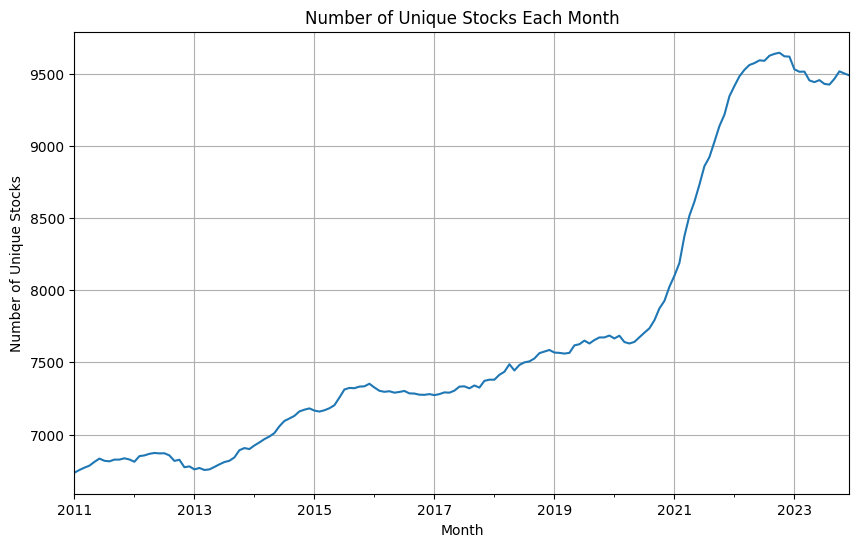

In [ ]:
# Count unique stocks per month
unique_stocks_per_month = cleaned_data.groupby('date')['permno'].nunique()
print("Unique stocks per month:\n", unique_stocks_per_month)

plt.figure(figsize=(10, 6))
unique_stocks_per_month.plot(kind='line')
plt.title('Number of Unique Stocks Each Month')
plt.xlabel('Month')
plt.ylabel('Number of Unique Stocks')
plt.grid(True)
plt.show()

2.2 Filter the stock returns data you retrieved from WRDS in Question 1 to only include the stock returns for the Dow Jones Stock Index, name it as filter_cleaned_data. Calculate the excess return for each stock. (5 marks)

In [ ]:
# Filter the stock returns data to include only the Dow Jones stocks
filter_cleaned_data = cleaned_data[cleaned_data['ticker'].isin(dow_jones_ticker_list)]

# Calculate the excess return for each stock using the 'rf' column for the risk-free rate
filter_cleaned_data['excess_return'] = filter_cleaned_data['mthret'] - filter_cleaned_data['rf']

filter_cleaned_data

,permno,siccd,mthcaldt,mthret,mthretx,mthcap,ticker,year,month,date,mktrf,smb,hml,rf,excess_return
12,10107,7370,2010-12-31,0.105018,0.105018,2.345277e+08,MSFT,2010,12,NaT,NaN,NaN,NaN,NaN,NaN
17,10145,3724,2010-12-31,0.069403,0.069403,4.147400e+07,HON,2010,12,NaT,NaN,NaN,NaN,NaN,NaN
129,11308,2086,2010-12-31,0.041159,0.041159,1.527202e+08,KO,2010,12,NaT,NaN,NaN,NaN,NaN,NaN
455,12490,3571,2010-12-31,0.037466,0.037466,1.823289e+08,IBM,2010,12,NaT,NaN,NaN,NaN,NaN,NaN
481,14008,2830,2010-12-31,0.041943,0.041943,5.116680e+07,AMGN,2010,12,NaT,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1205824,86580,3670,2023-12-29,0.058932,0.058841,1.223193e+09,NVDA,2023,12,2023-12-01,0.0487,0.0636,0.0492,0.0043,0.054632
1205844,86868,6211,2023-12-29,0.129502,0.129502,1.258042e+08,GS,2023,12,2023-12-01,0.0487,0.0636,0.0492,0.0043,0.125202
1206405,90215,7372,2023-12-29,0.044621,0.044621,2.547195e+08,CRM,2023,12,2023-12-01,0.0487,0.0636,0.0492,0.0043,0.040321
1207146,92611,7389,2023-12-29,0.014298,0.014298,4.120101e+08,V,2023,12,2023-12-01,0.0487,0.0636,0.0492,0.0043,0.009998


2.3 Calculate the mean and the covariance matrix of the selected stock returns. (10 marks)


In [ ]:
# Calculate the mean excess return for each stock
mean_returns = filter_cleaned_data.groupby('ticker')['excess_return'].mean()

# Calculate the covariance matrix of excess returns
cov_matrix = filter_cleaned_data.pivot(index='mthcaldt', columns='ticker', values='excess_return').cov()

np.set_printoptions(precision=6, suppress=True)


# Display results
print(f"the mean of stock returns are: \n{mean_returns}\n")
print(f"the covariance of stock returns are: \n{cov_matrix}")

the mean of stock returns are: 
ticker
AAPL    0.021624
AMGN    0.014029
AMZN    0.021140
AXP     0.012370
BA      0.014688
CAT     0.012363
CRM     0.016577
CSCO    0.010010
CVX     0.008297
DIS     0.008578
GS      0.009453
HD      0.017695
HON     0.011786
IBM     0.005091
JNJ     0.008559
JPM     0.013255
KO      0.006557
MCD     0.011272
MMM     0.005074
MRK     0.010842
MSFT    0.019497
NKE     0.013230
NVDA    0.039513
PG      0.007982
SHW     0.017927
TRV     0.010683
UNH     0.019376
V       0.018812
VZ      0.004776
WMT     0.009278
Name: excess_return, dtype: float64

the covariance of stock returns are: 
ticker      AAPL      AMGN      AMZN       AXP        BA       CAT       CRM  \
ticker                                                                         
AAPL    0.006284  0.001223  0.003295  0.001943  0.002128  0.001773  0.003667   
AMGN    0.001223  0.004132  0.001324  0.001213  0.001671  0.001804  0.001273   
AMZN    0.003295  0.001324  0.007452  0.002032  0.002330

2.4 Calculate the sharpe ratio of the selected stocks (5 marks)

In [ ]:
mean_returns = filter_cleaned_data[['ticker','excess_return']].groupby('ticker').mean().reset_index()
std_returns = filter_cleaned_data[['ticker','excess_return']].groupby('ticker')['excess_return'].std().reset_index()
sharpe_data = pd.merge(mean_returns, std_returns, on='ticker',suffixes=('_mean', '_std'))
sharpe_data['sharpe_ratio'] = sharpe_data['excess_return_mean'] / sharpe_data['excess_return_std']

# Identify the stock with the highest and lowest Sharpe ratio
highest_sharpe_stock = sharpe_data.loc[sharpe_data['sharpe_ratio'].idxmax()]
lowest_sharpe_stock = sharpe_data.loc[sharpe_data['sharpe_ratio'].idxmin()]
print(f"the sharpe ratio of selected stocks: \n{sharpe_data[['ticker', 'sharpe_ratio']]}\n")
print(f"the stock with the highest sharpe ratio is: \n{highest_sharpe_stock['ticker']}\n")
print(f"the stock with the lowest sharpe ratio is: \n{lowest_sharpe_stock['ticker']}\n")

the sharpe ratio of selected stocks: 
   ticker  sharpe_ratio
0    AAPL      0.272793
1    AMGN      0.218243
2    AMZN      0.244898
3     AXP      0.177779
4      BA      0.147534
5     CAT      0.145624
6     CRM      0.182546
7    CSCO      0.140991
8     CVX      0.113683
9     DIS      0.112423
10     GS      0.113639
11     HD      0.301587
12    HON      0.205264
13    IBM      0.084193
14    JNJ      0.197218
15    JPM      0.179138
16     KO      0.148599
17    MCD      0.248122
18    MMM      0.086471
19    MRK      0.205896
20   MSFT      0.322723
21    NKE      0.186645
22   NVDA      0.303234
23     PG      0.180331
24    SHW      0.269259
25    TRV      0.192080
26    UNH      0.344360
27      V      0.335544
28     VZ      0.098772
29    WMT      0.183793

the stock with the highest sharpe ratio is: 
UNH

the stock with the lowest sharpe ratio is: 
IBM



### **Part III - Static Portfolio Choice - Apply mean-variance method based

*   List item
*   List item

on historical returns and variance**

### **Question 3: Apply mean variance optimization method to estimate the optimal weights. (60 marks)**

In this question, you use the data retrieved in Question 1, the historical mean returns and covariance matrix calculated in Question 2 for the 30 selected stock returns, to apply mean-variance optimization method to determine the optimal weights. The tickers for the 30 stocks are ["MMM", "AMZN", "AXP", "AMGN", "AAPL", "BA", "CAT", "CVX", "CSCO", "KO", "GS", "HD", "HON", "IBM", "JNJ", "JPM", "MCD", "MRK", "MSFT", "NKE", "NVDA", "PG", "CRM", "SHW", "TRV", "UNH", "VZ", "V", "WMT", "DIS"].

You are welcome to compare your answers with those obtained using outside packages. For example, *PyPortfolioOpt* is a package that modulizes the process of portfolio optimization. This comnparison will be an **OPTIONAL** part of the assignment, that is, it is not required to receive full marks.

- For the optimization package you use, we suggest either *cvxpy (cp.Problem)* or *scipy (scipy.optimize)*.
- Stock returns data in CRSP are on a monthly basis. To calculate the monthly expected return and volatility with PyPortfolioOpt package, you need set 'frequency = 1'.

**Question 3.1**
Calculate the expected **monthly** returns `mu` using historical data. **OPTIONAL**: Validate your results using PyPortfolioOpt. (5 marks)

**Question 3.2**
Calculate the **monthly** covariance matrix `S` from historical data. **OPTIONAL**: Validate your results using PyPortfolioOpt. (5 marks)

**Question 3.3 Unconstrained optimization (10 marks)**

Determine the portfolio weights of the minimized volatility portfolio.

Calculate the portfolio returns, volatility, and Sharpe Ratio of this minimized volatility portfolio. When calculating the Sharpe ratio, assume **annualized** `risk_free_rate = 0.02`.


**Question 3.4 Constrained optimization with target expected return (10 marks)**

Determine the optimal portfolio that minimizes volatility for a given target expected **monthly** return of 1%. Use the expected monthly returns and monthly covariance matrix calculated above.

Compute the expected **monthly** return, volatility, and Sharpe ratio of the optimized portfolio with target return of 1%.  When calculating the Sharpe ratio, assume monthly `risk_free_rate = 0.002`. **OPTIONAL**: compare your results with PyPortfolioOpt.

**Question 3.5 Constrained optimization with target volatility (10 marks)**

Determine the optimal portfolio weights that maximize the Sharpe ratio for a given target risk of 20%. Use the expected returns and covariance matrix calculated above (convert to annualized version).

Calculate the portfolio returns, volatility, and Sharpe Ratio of the optimized portfolio with target risk 20%. When calculating the Sharpe ratio, assume `risk_free_rate = 0.02`.

**Question 3.6 Efficient frontier (20 marks)**

(1).Draw the efficient frontier by determing the minimized volatility portfolios over different target returns. Use target returns ranging from the minimized stock returns you calculated in Quesion 3.3 (expected returns of the minimized volatility portfolio) to the largest individual stock's expected return (the highest expected return you can get without short selling). You can utilize `ef.efficient_return` from PyPortfolioOpt or implement your own function. (10 marks)

(2).Individual Assets: Plot all individual assets on the expected return-volatility space. Do all individual assets fall below the efficient frontier? Verify and explain. (5 marks)

(3).Efficient Risk Portfolio: Draw the tangency portfolio on the efficient frontier (the portfolio that maximizes the Sharpe ratio). Analyze how the tangency portfolio changes as the risk-free rate varies (`risk_free_rate = 0%`, `2%`, `4%`). Provide an explanation based on economic intuition, not mathematical derivations. (5 marks)

In [ ]:
returns = filter_cleaned_data.set_index(['date','ticker'])['return'].unstack()
returns

3.1 Calculate the expected **monthly** returns `mu` using historical data. **OPTIONAL**: Validate your results using PyPortfolioOpt. (5 marks)

3.2 Calculate the **monthly** covariance matrix `S` from historical data. **OPTIONAL**: Validate your results using PyPortfolioOpt. (5 marks)

3.3. Unconstrained optimization (10 marks)

Determine the portfolio weights of the minimized volatility portfolio.

Calculate the portfolio returns, volatility, and Sharpe Ratio of this minimized volatility portfolio. When calculating the Sharpe ratio, assume **annualized** `risk_free_rate = 0.02`.

3.4 Constrainted optimization with target expected returns (10 marks)

Determine the optimal portfolio that minimizes volatility for a given target expected **monthly** return of 1%. Use the expected monthly returns and monthly covariance matrix calculated above.

Compute the expected **monthly** return, volatility, and Sharpe ratio of the optimized portfolio with target return of 1%.  When calculating the Sharpe ratio, assume monthly `risk_free_rate = 0.002`. **OPTIONAL**: compare your results with PyPortfolioOpt.


3.5 Constrained optimization with target volatility (10 marks)

Determine the optimal portfolio weights that maximize the Sharpe ratio for a given target risk of 20%. Use the expected returns and covariance matrix calculated above (convert to annualized version).

Calculate the portfolio returns, volatility, and Sharpe Ratio of the optimized portfolio with target risk 20%. When calculating the Sharpe ratio, assume `risk_free_rate = 0.02`.

3.6 Efficient Frontier (20 marks)

(1).Draw the efficient frontier by determing the minimized volatility portfolios over different target returns. Use target returns ranging from the minimized stock returns you calculated in Quesion 3.3 (expected returns of the minimized volatility portfolio) to the largest individual stock's expected return (the highest expected return you can get without short selling). You can utilize `ef.efficient_return` from PyPortfolioOpt or implement your own function. (10 marks)

(2).Individual Assets: Plot all individual assets on the expected return-volatility space. Do all individual assets fall below the efficient frontier? Verify and explain. (5 marks)

(3).Efficient Risk Portfolio: Draw the tangency portfolio on the efficient frontier (the portfolio that maximizes the Sharpe ratio). Analyze how the tangency portfolio changes as the risk-free rate varies (`risk_free_rate = 0%`, `2%`, `4%`). Provide an explanation based on economic intuition, not mathematical derivations. (5 marks)
